# Deuxième partie : tentatives de modélisation
## Initialisation
Important : le fichier de données doit se trouver dans le répertoire courant.

In [1]:
from IPython.display import display
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MultiLabelBinarizer
import sys
import warnings

pd.options.display.float_format = '{:,.3f}'.format
input_file = 'imdb.csv' # nom du fichier traité par le 1er notebook

print(f"Version de matplotlib : {matplotlib.__version__}")
print(f"Version de pandas : {pd.__version__}")
print(f"Version de Python : {sys.version}")

Version de matplotlib : 3.0.3
Version de pandas : 0.24.2
Version de Python : 3.6.8 |Anaconda custom (64-bit)| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]


### Chargement des données

In [2]:
data = pd.read_csv(input_file, delimiter='\t', keep_default_na=False)
print(f"Taille du tableau de données : {data.shape}")
print(f"Nombre de valeurs manquantes : {data.isnull().sum().sum()}")

Taille du tableau de données : (4847, 61)
Nombre de valeurs manquantes : 0


### Désignation de `id` comme index

In [3]:
data.set_index('id', inplace=True)

## Exploration sommaire
### Visualisation de la distribution des colonnes numériques

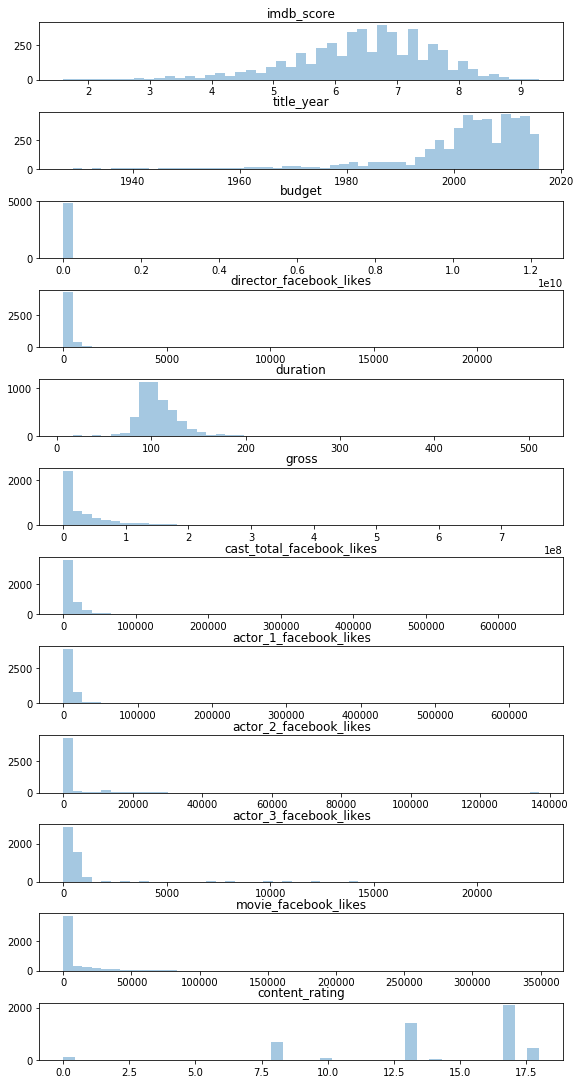

In [4]:
columns = ['imdb_score', 'title_year', 'budget', 
           'director_facebook_likes', 'duration', 
           'gross', 
           'cast_total_facebook_likes',
           'actor_1_facebook_likes', 
           'actor_2_facebook_likes', 
           'actor_3_facebook_likes', 
           'movie_facebook_likes', 
           'content_rating']
n = len(columns)
fig, axes = plt.subplots(n, 1, figsize=(8, 15))
fig.tight_layout()
for i, c in enumerate(columns):
    with warnings.catch_warnings():
        # https://github.com/mwaskom/seaborn/issues/1392    
        warnings.filterwarnings('ignore') 
        sns.distplot(a=data[c], ax=axes[i], kde=False, norm_hist=False)\
            .set_title(c);
        axes[i].set_xlabel('');

In [5]:
for c in columns:
    print(f"Nombre de 0 dans la colonne {c} : {sum(data[c] == 0)}")

Nombre de 0 dans la colonne imdb_score : 0
Nombre de 0 dans la colonne title_year : 0
Nombre de 0 dans la colonne budget : 456
Nombre de 0 dans la colonne director_facebook_likes : 946
Nombre de 0 dans la colonne duration : 0
Nombre de 0 dans la colonne gross : 799
Nombre de 0 dans la colonne cast_total_facebook_likes : 31
Nombre de 0 dans la colonne actor_1_facebook_likes : 31
Nombre de 0 dans la colonne actor_2_facebook_likes : 60
Nombre de 0 dans la colonne actor_3_facebook_likes : 100
Nombre de 0 dans la colonne movie_facebook_likes : 2118
Nombre de 0 dans la colonne content_rating : 122


### Distribution du pays et de la langue

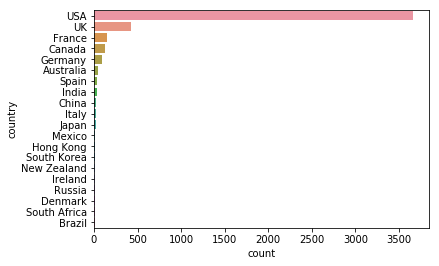

In [6]:
axes = sns.countplot(y="country", data=data, order=data.country.value_counts().iloc[:20].index)

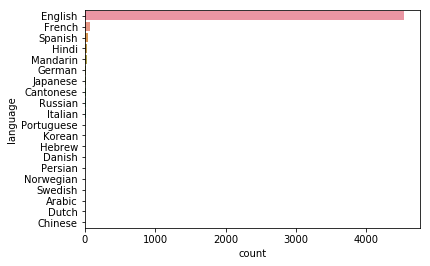

In [7]:
axes = sns.countplot(y="language", data=data, order=data.language.value_counts().iloc[:20].index)

### Analyse de la corrélation entre colonnes de scores

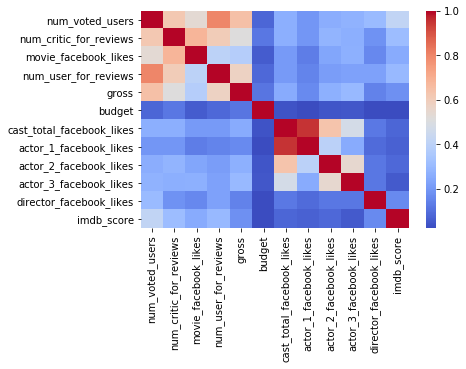

In [8]:
cols = ['num_voted_users',
        'num_critic_for_reviews', 
        'movie_facebook_likes', 
        'num_user_for_reviews', 
        'gross', 'budget', 
        'cast_total_facebook_likes',
        'actor_1_facebook_likes',
        'actor_2_facebook_likes',
        'actor_3_facebook_likes', 
        'director_facebook_likes',
        'imdb_score'
       ]
data_partial = data[cols]
corr = data_partial.corr()
sns.heatmap(corr, cmap='coolwarm',
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

Conclusions : 
 - `num_voted_users` est fortement corrélé avec `num_critic_for_reviews`, `movie_facebook_likes`, `num_user_for_reviews` et `gross` ; nous pouvons donc ne conserver que ce premier attribut.
 - De même `cast_total_facebook_likes` est fortement corrélé avec `actor_1_facebook_likes`, que nous ignorerons.
 - Par cohérence et pour simplifier, nous ignorerons également `actor_2_facebook_likes` et `actor_3_facebook_likes`.

### Suppression des colonnes inutiles

In [9]:
drop_cols = ['num_critic_for_reviews', 
             'movie_facebook_likes',
             'num_user_for_reviews',
             'gross',
             'actor_1_facebook_likes',
             'actor_2_facebook_likes',
             'actor_3_facebook_likes']
data.drop(columns=drop_cols, errors='ignore', inplace=True)
# Supprime également la version normalisée
data.drop(columns=['adj_' + c for c in drop_cols], errors='ignore', inplace=True)

### Élimination des colonnes brutes, avant normalisation

In [10]:
# Liste des colonnes dont il existe une version normalisée
drop_cols = [c[4:] for c in data.columns if c.startswith('adj_')]
# Nous aurons besoin de `imdb_score`
if 'imdb_score' in drop_cols:
    drop_cols.remove('imdb_score')
data.drop(columns=drop_cols, errors='ignore', inplace=True)

### Colonnes restantes autre que `genre_*`

In [11]:
[c for c in data.columns if not(c.startswith('genre_'))]

['director_name',
 'actor_2_name',
 'genres',
 'actor_1_name',
 'movie_title',
 'actor_3_name',
 'plot_keywords',
 'movie_imdb_link',
 'language',
 'country',
 'imdb_score',
 'adj_imdb_score',
 'adj_title_year',
 'adj_budget',
 'adj_director_facebook_likes',
 'adj_duration',
 'adj_cast_total_facebook_likes',
 'adj_content_rating',
 'adj_num_voted_users']

## Création d'une distance sur l'espace des films
### Méthode simple de mesure de distance entre 2 ensembles de mots-clefs

In [12]:
def dist_between_keywords(id1, id2):
    kw1 = set(data.loc[id1].plot_keywords.split('|'))
    kw2 = set(data.loc[id2].plot_keywords.split('|'))
    intersection = kw1.intersection(kw2)
    n = min(len(kw1), len(kw2))
    return (n - len(intersection)) / n

# Test, avec résultat attendu = 4 / 5 = 0.8
dist_between_keywords('tt0378407', 'tt0270980') 

0.8

### Liste des colonnes à considérer

In [13]:
# colonnes de genre
numeric_columns = [col for col in data if col.startswith('genre_')] 
# colonnes numériques (après normalisation)
numeric_columns.append('adj_budget') # petite ou grosse production
numeric_columns.append('adj_cast_total_facebook_likes') # popularité du réalisateur
numeric_columns.append('adj_director_facebook_likes') # popularité du réalisateur
numeric_columns.append('adj_duration') # longueur
numeric_columns.append('adj_imdb_score') # note imdb
numeric_columns.append('adj_title_year') # époque du film
numeric_columns.append('adj_num_voted_users')
numeric_columns.append('adj_content_rating') # classification
# colonnes non numériques 
category_columns = ['director_name', 'country', 'language']
# colonnes à fusionner
set_columns = ['actor_1_name', 'actor_2_name', 'actor_3_name']
# colonne de mots-clefs
keyword_column = 'plot_keywords'

### Fonction de calcul de distance

In [14]:
def dist1(id1, id2, metric):
    """ Calcule la distance euclidienne entre 2 films
    """
    film1 = data.loc[id1]
    film2 = data.loc[id2]
    n = len(numeric_columns) + len(category_columns) + 2
    v1 = np.zeros(n).reshape(1, n)
    v2 = np.zeros(n).reshape(1, n)
    # pour les attributs numériques, pas de changement
    for i, col in enumerate(numeric_columns):
        v1[0, i] = film1[col]
        v2[0, i] = film2[col]
    # teste l'égalité des attributs catégoriels
    for i, col in enumerate(category_columns):
        v2[0, len(numeric_columns)+i] = 0 if film1[col] == film2[col] else 1    
    # calcule le nb d'éléments communs aux 2 ensembles
    set1 = { film1[col] for col in set_columns }
    set2 = { film2[col] for col in set_columns }
    size = len(set1)
    v2[0, n-2] = (size - len(set1.intersection(set2))) / size
    # calcule le nombre de mots-clefs communs
    v2[0, n-1] = dist_between_keywords(id1, id2)
    return pairwise_distances(v1, v2, metric=metric)[0][0]

# test de validité
print(dist1('tt0068646','tt0099685', 'euclidean'))

2.004207682298129


### Example avec la distance euclidienne

In [15]:
movies = ['tt0068646', # The Godfather 
          'tt0071562', # The Godfather II
          'tt0099685', # Goodfellas
          'tt0110912', # Pulp Fiction
          'tt0072271', # The Texas Chainsaw Massacre
          'tt0083907', # Evil Dead
          'tt0084516', # Poltergeist
          'tt0387564', # Saw
          'tt0114709', # Toy Story
          'tt0435761', # Toy Story 3
          'tt0266543', # Finding Nemo
          'tt0029583'] # Snow White
distances = pd.DataFrame(index=movies, columns=movies, dtype=float)
for x in movies:
    for y in movies:
        distances.loc[x, y] = dist1(x, y, 'euclidean')
distances

,tt0068646,tt0071562,tt0099685,tt0110912,tt0072271,tt0083907,tt0084516,tt0387564,tt0114709,tt0435761,tt0266543,tt0029583
tt0068646,0.000,1.080,2.004,1.886,2.730,2.724,2.774,2.903,3.333,3.352,3.181,3.119
tt0071562,1.080,0.000,2.012,1.908,2.695,2.690,2.737,2.876,3.323,3.337,3.173,3.093
tt0099685,2.004,2.012,0.000,2.033,2.954,2.950,2.990,3.107,3.526,3.536,3.383,3.347
tt0110912,1.886,1.908,2.033,0.000,2.845,2.835,2.879,2.983,3.401,3.412,3.244,3.255
tt0072271,2.730,2.695,2.954,2.845,0.000,2.238,2.064,2.032,3.325,3.337,3.182,3.054
tt0083907,2.724,2.690,2.950,2.835,2.238,0.000,1.804,2.465,3.001,3.010,3.172,2.720
tt0084516,2.774,2.737,2.990,2.879,2.064,1.804,0.000,2.515,2.886,2.894,3.063,2.697
tt0387564,2.903,2.876,3.107,2.983,2.032,2.465,2.515,0.000,3.456,3.453,3.309,3.276
tt0114709,3.333,3.323,3.526,3.401,3.325,3.001,2.886,3.456,0.000,1.336,2.003,2.612
tt0435761,3.352,3.337,3.536,3.412,3.337,3.010,2.894,3.453,1.336,0.000,2.004,2.655


### Identification des 3 points les plus proches d'un point donné

In [16]:
order = np.argsort(distances, axis=1) 
sorted = pd.DataFrame(distances.columns[order], distances.index)
sorted = sorted.applymap(lambda id : data.loc[id, 'movie_title'])
for i, row in sorted.iterrows():
    print(row[0] + "  ->  " + row[1] + ", " + row[2] + ", " + row[3])

The Godfather  ->  The Godfather: Part II, Pulp Fiction, Goodfellas
The Godfather: Part II  ->  The Godfather, Pulp Fiction, Goodfellas
Goodfellas  ->  The Godfather, The Godfather: Part II, Pulp Fiction
Pulp Fiction  ->  The Godfather, The Godfather: Part II, Goodfellas
The Texas Chain Saw Massacre  ->  Saw, Poltergeist, The Evil Dead
The Evil Dead  ->  Poltergeist, The Texas Chain Saw Massacre, Saw
Poltergeist  ->  The Evil Dead, The Texas Chain Saw Massacre, Saw
Saw  ->  The Texas Chain Saw Massacre, The Evil Dead, Poltergeist
Toy Story  ->  Toy Story 3, Finding Nemo, Snow White and the Seven Dwarfs
Toy Story 3  ->  Toy Story, Finding Nemo, Snow White and the Seven Dwarfs
Finding Nemo  ->  Toy Story, Toy Story 3, Snow White and the Seven Dwarfs
Snow White and the Seven Dwarfs  ->  Toy Story, Toy Story 3, Poltergeist


On note une association surprenante pour le dernier film ! Étant donné la taille réduite du jeu de données, nous ne nous en inquiétons pas. 

### Représentation graphique des distances 2 à 2

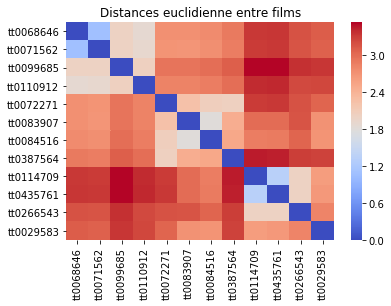

In [17]:
fig, axes = plt.subplots(1, 1);
sns.heatmap(data=distances, cmap='coolwarm', ax=axes);
axes.set_title('Distances euclidienne entre films');

### Avec la distance cosinus

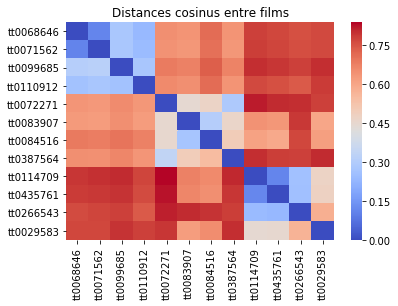

In [18]:
for x in movies:
    for y in movies:
        distances.loc[x, y] = dist1(x, y, 'cosine')
fig, axes = plt.subplots(1, 1);
sns.heatmap(data=distances, cmap='coolwarm', ax=axes);
axes.set_title('Distances cosinus entre films');

On observe une meilleure discrimination qu'avec la distance euclidienne.

## Partionnement ('clustering') de l'espace des films
### Création d'un sous-tableau de données

In [19]:
cols = [col for col in data if col.startswith('genre_')]
#cols.extend(['adj_duration', 'adj_num_voted_users',
#             'adj_cast_total_facebook_likes',
#             'adj_content_rating', 'adj_title_year', 
#             'adj_imdb_score', 'adj_budget']) 
cols.extend(['adj_content_rating', 'adj_title_year', 'adj_imdb_score'])
X = data[cols]
print(f"Nombre de colonnes : {len(cols)}")

Nombre de colonnes : 25


### Préparation des indicateurs de mots-clefs
#### Création de la matrice d'indicateurs

Nombre de mots-clefs : 8043
Nb de mots-clefs avec plus de 5 films: 782
Nb de mots-clefs avec plus de 10 films: 371
Nb de mots-clefs avec plus de 15 films: 228
Nb de mots-clefs avec plus de 20 films: 152


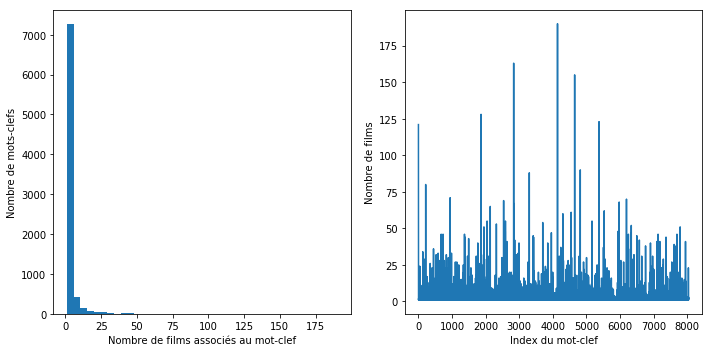

In [20]:
cv = CountVectorizer(tokenizer=lambda s: s.split("|"))
plot_kw = cv.fit_transform(data['plot_keywords']).todense()
plot_kw_list = ['kw_' + kw.replace(' ', '_') for kw in cv.get_feature_names()]
print(f"Nombre de mots-clefs : {len(plot_kw_list)}")
subtotals = np.squeeze(np.asarray(plot_kw.sum(axis=0)))
for n in range(5, 25, 5):
    print(f"Nb de mots-clefs avec plus de {n} films: {sum(subtotals > n)}")
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].hist(subtotals, bins=40);
axes[0].set_xlabel('Nombre de films associés au mot-clef')
axes[0].set_ylabel('Nombre de mots-clefs')
axes[1].plot(subtotals);
axes[1].set_xlabel('Index du mot-clef');
axes[1].set_ylabel('Nombre de films');
fig.tight_layout()

Commentaires : 1) peu d'info 2) variable binaire donc pas idéale pour K-means.

#### Suppression de la colonne indiquant l'absence de mot-clef
En effet il n'y a aucune similarité entre les films appartenant à cette catégorie.

In [21]:
key = 'kw_' # Indique l'absence de mot-clef
if key in plot_kw_list:
    print(f"Taille de la matrice avant suppression : {plot_kw.shape}")
    pos = plot_kw_list.index(key)
    print(f"Index de la colonne à effacer : {pos}")
    plot_kw = np.delete(plot_kw, pos, axis=1)
    plot_kw_list.remove(key)
    print(f"Taille de la matrice après suppression : {plot_kw.shape}")

Taille de la matrice avant suppression : (4847, 8043)
Index de la colonne à effacer : 0
Taille de la matrice après suppression : (4847, 8042)


### Réduction de dimensionnalité par seuil de variance

Variance min. = 0.00020627061828276368, variance max. = 0.03766290366800544


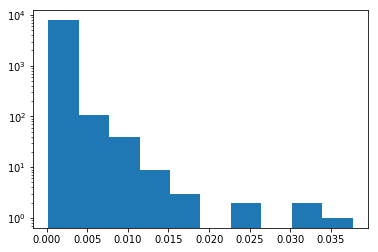

In [22]:
selector = VarianceThreshold()
selector.fit_transform(plot_kw)
v = selector.variances_
plt.hist(v, bins=10, log=True);
print(f"Variance min. = {min(v)}, variance max. = {max(v)}")

Nous pourrions procéder à une réduction de dimension en supprimant les colonnes avec la variance la plus faible, car leur pouvoir prédictif sera limité. Nous fixons initialement le seuil d'exclusion à 20% de la variance maximale.

In [23]:
def variance_threshold_selector(matrix, labels, threshold):
    selector = VarianceThreshold(threshold)
    selector.fit(matrix)
    col_indices = selector.get_support(indices=True)
    print(f"Nombre de colonnes retenues : {len(col_indices)}")
    names = [labels[i] for i in col_indices]
    return pd.DataFrame(matrix[:, col_indices], columns=names, index=data.index)
# Test avec résultat attendu : 0, 1, 0
variance_threshold_selector(plot_kw, plot_kw_list, 0.03).loc['tt0036868', :]

Nombre de colonnes retenues : 3


kw_friend    0
kw_love      1
kw_murder    0
Name: tt0036868, dtype: int64

In [24]:
variance_threshold = max(v) * 0.2
df_plot_kw = variance_threshold_selector(plot_kw, plot_kw_list, variance_threshold)
df_plot_kw

Nombre de colonnes retenues : 60


,kw_alien,kw_battle,kw_best_friend,kw_box_office_flop,kw_boy,kw_christmas,kw_cia,kw_college,kw_cult_film,kw_death,...,kw_teacher,kw_teenager,kw_terrorist,kw_texas,kw_train,kw_vampire,kw_violence,kw_vomiting,kw_wedding,kw_writer
id,,,,,,,,,,,,,,,,,,,,,
tt5574490,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt5215952,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
tt5116280,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt5078326,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt5001130,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt4939066,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt4877736,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt4871980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt4824308,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Amélioration : mesure de la fréquence d'apparition des mots-clefs
Application à la matrice non normalisée d'apparition des mots-clefs (produite par `CountVectorizer`).

In [25]:
fv = TfidfVectorizer(tokenizer=lambda s: s.split("|"))
plot_kw_freq = fv.fit_transform(data['plot_keywords']).todense()
plot_kw_freq_list = ['kw_' + kw.replace(' ', '_') for kw in fv.get_feature_names()]
key_to_delete = 'kw_'
if key_to_delete in plot_kw_freq_list:
    pos = plot_kw_freq_list.index(key_to_delete)
    plot_kw_freq = np.delete(plot_kw_freq, pos, axis=1)
    plot_kw_freq_list.remove(key_to_delete)
print(f"Égalité des 2 listes de mots-clefs : {plot_kw_list == plot_kw_freq_list}")

Égalité des 2 listes de mots-clefs : True


Valeur maximale de TF-IDF pour le film : Luther


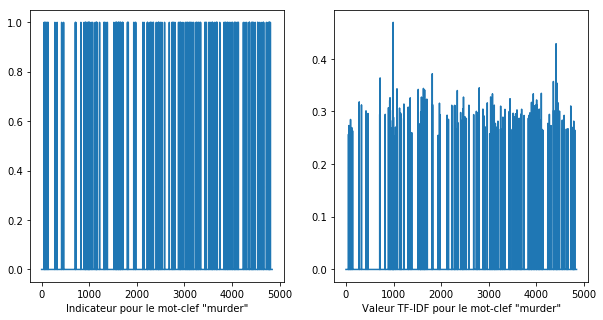

In [26]:
col = plot_kw_freq_list.index('kw_murder')
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(plot_kw[:, col]);
axes[0].set_xlabel('Indicateur pour le mot-clef "murder"')
axes[1].plot(plot_kw_freq[:, col]);
axes[1].set_xlabel('Valeur TF-IDF pour le mot-clef "murder"');
max_index = np.argmax(plot_kw_freq[:, col])
print(f"Valeur maximale de TF-IDF pour le film : {data['movie_title'][max_index]}")

Fusionner les 2 graphes.

### Réduction de dimensionnalité par ACP
Application à la matrice normalisée (TF-IDF).
#### Analyse sans réduction du nombre de composants

In [27]:
pca = PCA()
pca.fit(plot_kw_freq);

MemoryError: 

In [ ]:
variances = pca.explained_variance_ratio_
ev = pca.singular_values_ # valeurs propres
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Premier graphe avec tous les facteurs
ax[0].plot(ev**2 / sum(ev**2));
ax[0].set_xlabel('Facteur');
ax[0].set_ylabel('% de variance expliquée par facteur');
ax[0].set_xticks([0, 100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000])
ax[0].set_xticklabels([0, '', '', '', '', 500, 1000, 2000, 3000, 4000, 5000])
# Gros plan sur les facteurs plus gros contributeurs
ax[1].plot(np.cumsum(ev[0:500]**2 / sum(ev**2)));
ax[1].set_xlabel('Nombre de facteurs');
ax[1].set_ylabel('% de variance expliquée cumulativement');
fig.tight_layout()

Le premier graphique confirme qu'au-delà une centaine de facteurs, l'explication de variance par les facteurs suivants est très faible. Malheureusement le deuxième graphe montre qu'avec 150 facteurs on n'explique qu'environ 20% de la variance totale.

#### Calibration d'un modèle d'ACP avec un nombre réduit de dimensions

In [ ]:
dims = 150
pca = PCA(n_components=dims)
plot_kw_pca = pca.fit_transform(plot_kw_freq);
print(f"Dimension de la matrice de mots-clefs après ACP : {plot_kw_pca.shape}")

#### Vérification manuelle
Il n'y a rien de très rigoureux dans ce qui suit, nous cherchons juste à nous convaincre en examinant un exemple simple que le changement de base est effectué correctement.

In [ ]:
factor = 0
ev = pca.components_[factor, :] # Facteur choisi
coeff_loc = np.where(ev >= 0.3) 
kw1 = coeff_loc[0][0] # 1er coeff non négligeable
kw2 = coeff_loc[0][1] # 2e coeff non négligeable
movie = 785 # Film choisi pour avoir ces 2 mots-clefs
fig, axes = plt.subplots()
axes.plot(ev)
axes.set_xlabel('Index de mot-clef')
axes.set_ylabel(f'Poids dans facteur {factor}')
print(f"Code du film : {data.index[movie]}")
print(f"Mots-clefs : {plot_kw_list[kw1]}, {plot_kw_list[kw2]}")
print(f"Position des 2 mots-clefs : {kw1}, {kw2}")
print(f"Poids dans 1er vecteur ACP : {ev[kw1]}, {ev[kw2]}")
print(f"Coefficients de kw1 et kw2 : {plot_kw_freq[movie, kw1]}, {plot_kw_freq[movie, kw2]}")
# Valeur attendue approximativement : 
#- environ 1.2 on utilise CountVectorizer
#- environ 0.45 si on utilise TF-IDF
print(f"Première coordonnée dans la nouvelle base : {plot_kw_pca[movie, 0]}")

#### Ajout au tableau de données

In [ ]:
pca_cols = [ 'ACP' + str(c) for c in list(range(0, dims))]
df_kw = pd.DataFrame(plot_kw_pca, columns=pca_cols, index=X.index)
X1 = pd.concat([X, df_kw], axis=1)
print(f"Taille du tableau de données : {X1.shape}")
# Vérification - valeurs attendues : 0.35, 1.2 ou 0.45
X1.loc['tt1666186', ['adj_imdb_score', 'ACP0']] 

### Ajout du nom du réalisateur

In [ ]:
directors = data['director_name'].value_counts().sort_values(ascending=False)
print(f"Nombre de réalisateurs : {len(directors)}")
print(f"Nombre de réalisateurs avec plus de 10 films: {sum(directors > 10)}")
directors.hist(bins=50, figsize=(12, 4));

Nous retenons donc les 30 premiers réalisateurs, les suivants n'ayant pas assez de films pour nous permettre d'établir des rapprochements entre films.

In [ ]:
n_directors = 30
cv = CountVectorizer(tokenizer=lambda s: s.split("|"), 
                     max_features=n_directors)
directors = cv.fit_transform(data['director_name'])
director_list = ['dir_' + d.replace(' ', '_') for d in cv.get_feature_names()]
print(f"Taille de la matrice de réalisateurs : {directors.shape}")
df_directors = pd.DataFrame(directors.todense(), 
                            columns=director_list, index=X.index)
X2 = pd.concat([X1, df_directors], axis=1)
print(f"Nouvelle taille du tableau de données : {X2.shape}")
# Vérification - valeurs attendues : 0.92, 0, 1
X2.loc['tt0068646', ['adj_imdb_score', 
                     'dir_steven_spielberg', 
                     'dir_francis_ford_coppola']]

### Ajout du pays
Étant donnée la distribution de la variable `country` (voir plus haut), nous ne retenons que les 12 valeurs les plus courantes.

In [ ]:
n_countries = 12
cv = CountVectorizer(tokenizer=lambda s: s.split("|"), max_features=n_countries)
countries = cv.fit_transform(data['country'])
country_list = ['country_' + d.replace(' ', '_') for d in cv.get_feature_names()]
print("Liste des colonnes de pays :", ", ".join(country_list))
print(f"Taille de la matrice de pays : {countries.shape}")
df_countries = pd.DataFrame(countries.todense(), columns=country_list, index=X.index)
X3 = pd.concat([X2, df_countries], axis=1)
print(f"Nouvelle taille du tableau de données : {X3.shape}")
# Vérification - valeurs attendues : 0.82, 0, 1
X3.loc['tt4262980', ['adj_imdb_score', 'country_germany', 'country_japan']]

Afin de limiter la taille du tableau de données, nous renonçons à créer des colonnes indicatrices des acteurs et de la langue.
### Optimisation du nombre de partitions

In [ ]:
n_clusters_vals = [40, 60, 80, 100, 150, 200, 300, 400, 500]
for n_clusters in n_clusters_vals:
    np.random.seed(42) # Rend les résultats reproductibles
    model = KMeans(n_clusters=n_clusters)
    categories = model.fit_predict(X3)
    sil_avg = silhouette_score(X3, categories)
    min_count = min(pd.DataFrame(categories, columns=['category'])['category'].value_counts())
    print(f"Avec {n_clusters} partitions, score de silhouette moyen = "
          f"{sil_avg:0.2f}, taille minimale = {min_count}.")

Pour la version pilote de notre outil de recommandation, nous retenons la valeur n_clusters = 100. Avec des valeurs supérieures on obtient un meilleur score de silhouette moyen, mais une taille minimale de partition trop faible.

Nous notons que le score de silhouette atteint est faible, mais meilleur que lorsque nous avions utilisé les indicateurs de mots-clefs non normalisés. Sa valeur maximale était alors 0,10.
### Calibration finale du modèle

In [ ]:
n_clusters = 80
np.random.seed(42)
model = KMeans(n_clusters=n_clusters)
categories = model.fit_predict(X3)
df_categories = pd.DataFrame(categories, index=data.index, columns=['category'])
print(f"Taille du tableau de catégories : {df_categories.shape}")

### Distribution des tailles de catégories

In [ ]:
sizes = df_categories['category'].value_counts()
print(f"Taille min. = {sizes.min()}, taille max. = {sizes.max()}, "
      f"taille médiane = {np.median(sizes)}.")
fig, axes = plt.subplots(figsize=(10, 4))
sizes.hist(bins=50, ax=axes);

Nous observons que tous les clusters ont une taille satisfaitante (jamais < 5).
## Exploitation des partitions pour faire des recommandations
### Liste des films dans la catégorie de Toy Story

In [ ]:
id = 'tt0114709' # Toy Story
cat = df_categories.loc[id, 'category']
print(f"Catégorie : {cat}")
cols = ['movie_title', 'genres', 'plot_keywords', 'imdb_score']
data.loc[df_categories['category']==cat, cols]\
    .sort_values(by='imdb_score', ascending=False)

### Création d'une fonction de recommandation
Une fois la partition du film identifiée, nous sélectionnons les n films avec le meilleur score ou les plus proches du film spécifié.

In [ ]:
def get_best_movies_in_cluster(id, n=5, sort_by='imdb_score'):
    cat = df_categories.loc[id, 'category']
    mask = (df_categories['category'] == cat) & (data.index != id)
    shortlist = data.loc[mask, ['movie_title', 'genres', 
                                'plot_keywords', 'imdb_score']]
    # Calcul de la distance
    dist = lambda movie: dist1(movie, id, 'cosine')
    shortlist['dist'] = shortlist.index.to_series().apply(dist)
    # Tri des résultats 
    sort_asc = False if sort_by == 'imdb_score' else True
    shortlist.sort_values(by=sort_by, ascending=sort_asc, inplace=True)
    return shortlist.iloc[0:n, :]

### Application aux exemples précédents
#### Recommandations avec les meilleurs scores

In [ ]:
get_best_movies_in_cluster('tt0068646', 5, 'imdb_score') # The Godfather

In [ ]:
get_best_movies_in_cluster('tt0114709', 5, 'imdb_score') # Toy Story

In [ ]:
get_best_movies_in_cluster('tt0029583', 5, 'imdb_score') # Snow White

#### Recommandations des films les plus similaires

In [ ]:
get_best_movies_in_cluster('tt0068646', 5, 'dist') # The Godfather

In [ ]:
get_best_movies_in_cluster('tt0114709', 5, 'dist') # Toy Story

In [ ]:
get_best_movies_in_cluster('tt0029583', 5, 'dist') # Snow White

## Visualisation des partitions

In [ ]:
tsne = TSNE(n_components=2, verbose=1, n_iter=300)
tsne_results = tsne.fit_transform(X3)
print(f"Taille du tableau en sortie : {tsne_results.shape}")

In [ ]:
markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', 
           '*', 'h', 'H', 'D', 'd', 'P', 'X']
markers_map = { i: markers[i % len(markers)] for i in range(0, n_clusters)}
fig, axis = plt.subplots(figsize=(8,8))
sns.scatterplot(x=tsne_results[:, 0], 
                y=tsne_results[:, 1],                 
                ax=axis,                     
                style=categories,           
                hue=categories,
                palette=sns.color_palette("Spectral", n_clusters),
                markers=markers_map,
                legend=False)\
   .set_title('Visualisation des partitions de films');